# Experiments for pipelined multi-step reconstruction

In [1]:
from rascil.processing_components import create_visibility_from_ms
from visibilities import *
from images import *
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib
import numpy
import helpers
import pandas as pd
import os

plt.set_loglevel("critical")
cmap='turbo'
matplotlib.rcParams['figure.figsize'] = [10, 5]

## Load all results and compute PSNRs

In [2]:
gts_multistep = [helpers.readFits("../data/SGRA_full_gt.fits"), helpers.readFits("../data/SGRB_full_gt.fits"), \
       helpers.readFits("../data/SGRC_full_gt.fits")]

cuts = [20, 35, 55]
hws = [5, 3, 1]
dataset_names = ["Sgr A", "Sgr B2", "Sgr C"]
actual_names = ["SGRA", "SGRB", "SGRC"]

data_low = []
data_high = []

for i, dataset in enumerate(actual_names):
    high_gt = gts_multistep[i]
    for j, cut in enumerate(cuts):
        for k, hw in enumerate(hws):
            curr_data_low = [dataset + " " + str(cut) + " " + str(hw)]
            curr_data_high = [dataset + " " + str(cut) + " " + str(hw)]
            
            low_filter = helpers.bandpass(high_gt, 0, cut + hw)
            low_gt = signal.fftconvolve(high_gt, low_filter, mode='same')
            
            curr_deconv_low = None
            curr_deconv_high = None
            for maj_iter in range(0, 5):
                high_filename = "../results/pipelined_results/" + dataset + "/" + str(cut) + "/" + str(hw) + "hw/high/" + \
                    "deconv_iteration_" + str(maj_iter) + "_channel_0.fits"
                low_filename = "../results/pipelined_results/" + dataset + "/" + str(cut) + "/" + str(hw) + "hw/low/" + \
                    "deconv_iteration_" + str(maj_iter) + "_channel_0.fits"
                
                deconv_low = helpers.readFits(low_filename)
                deconv_low = signal.fftconvolve(deconv_low, low_filter, mode='same')
                
                deconv_high = helpers.readFits(high_filename)
                
                if curr_deconv_low is None:
                    curr_deconv_low = deconv_low
                else:
                    curr_deconv_low += deconv_low
                
                if curr_deconv_high is None:
                    curr_deconv_high = deconv_high
                else:
                    curr_deconv_high += deconv_high
                
                psnr_low = helpers.compute_rmse(low_gt, curr_deconv_low)#helpers.compute_snr(low_gt, curr_deconv_low)
                psnr_high = helpers.compute_rmse(high_gt, curr_deconv_high)#helpers.compute_snr(high_gt, curr_deconv_high)
                curr_data_low.append(psnr_low)
                curr_data_high.append(psnr_high)
            
            data_low.append(curr_data_low)
            data_high.append(curr_data_high)

### Low step PSNRs (not taking into account transfer to high steps)

In [3]:
pd.DataFrame(data_low, columns=["Dataset", "1", "2", "3", "4", "5"])

,Dataset,1,2,3,4,5
0,SGRA 20 5,0.002258,0.001160,0.000856,0.000747,0.000717
1,SGRA 20 3,0.002272,0.001199,0.000795,0.000600,0.000474
2,SGRA 20 1,0.002229,0.001150,0.000765,0.000589,0.000485
3,SGRA 35 5,0.002354,0.001283,0.001012,0.000889,0.000850
4,SGRA 35 3,0.002276,0.001199,0.000887,0.000747,0.000681
5,SGRA 35 1,0.002260,0.001167,0.000796,0.000622,0.000519
6,SGRA 55 5,0.002291,0.001187,0.000871,0.000725,0.000662
7,SGRA 55 3,0.002352,0.001246,0.000941,0.000788,0.000725
8,SGRA 55 1,0.002287,0.001202,0.000916,0.000778,0.000719
9,SGRB 20 5,0.001027,0.000576,0.000466,0.000438,0.000403


### Full step PSNRs (not counting low major cycles)

In [4]:
pd.DataFrame(data_high, columns=["Dataset", "1", "2", "3", "4", "5"])

,Dataset,1,2,3,4,5
0,SGRA 20 5,0.002489,0.001503,0.001300,0.001217,0.001202
1,SGRA 20 3,0.002527,0.001545,0.001268,0.001138,0.001080
2,SGRA 20 1,0.002501,0.001517,0.001255,0.001138,0.001090
3,SGRA 35 5,0.002569,0.001594,0.001396,0.001294,0.001272
4,SGRA 35 3,0.002505,0.001538,0.001318,0.001215,0.001179
5,SGRA 35 1,0.002499,0.001525,0.001273,0.001157,0.001110
6,SGRA 55 5,0.002505,0.001537,0.001311,0.001214,0.001179
7,SGRA 55 3,0.002571,0.001595,0.001375,0.001267,0.001231
8,SGRA 55 1,0.002524,0.001580,0.001379,0.001284,0.001251
9,SGRB 20 5,0.001178,0.000697,0.000604,0.000570,0.000557


## Progression across major-cycles

#### For low

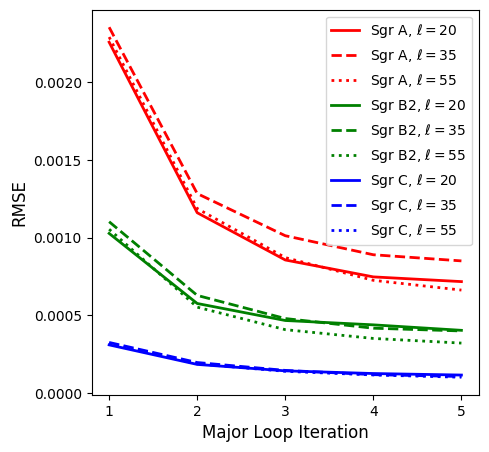

In [9]:
matplotlib.rcParams['figure.figsize'] = [5, 5]
from functools import partial

colours = ['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b']
colours2 = ['r', 'g', 'b']
styles = ['-', '--', ':', '-', '--', ':', '-', '--', ':']
labels = ["Sgr A, $\ell=20$", "Sgr A, $\ell=35$", "Sgr A, $\ell=55$", \
         "Sgr B2, $\ell=20$", "Sgr B2, $\ell=35$", "Sgr B2, $\ell=55$", \
         "Sgr C, $\ell=20$", "Sgr C, $\ell=35$", "Sgr C, $\ell=55$"]

labels2 = ["$\ell=20, \delta=5$", "$\ell=35, \delta=5$", "$\ell=55, \delta=5$"]

for i, data in enumerate(data_low[::3]):
    cleaned_data = data[1:]
    norm_factor = 1#numpy.max(cleaned_data)
    cleaned_data = [x / norm_factor for x in cleaned_data]

    plt.plot(range(1, 6), cleaned_data, c=colours[i], linestyle=styles[i], label=labels[i], lw=2)

plt.xticks([1,2,3,4,5])
    
plt.legend(loc="upper right", fontsize=10)
#plt.yscale('function', functions=(partial(numpy.power, 2.0), partial(numpy.emath.logn, 2.0)))
    
plt.xlabel("Major Loop Iteration", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.savefig("../figures/low_majcycle_conv.png", bbox_inches='tight')

#### For full

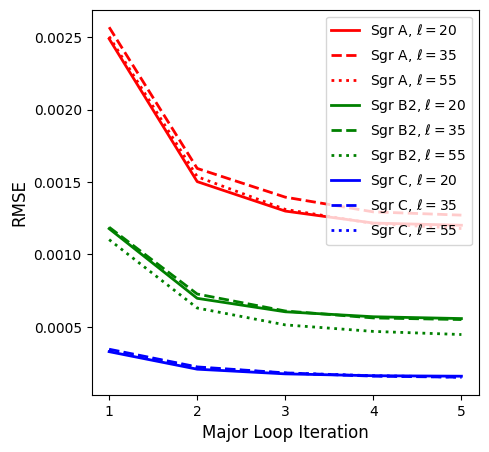

In [10]:
colours = ['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b']
colours2 = ['r', 'g', 'b']
styles = ['-', '--', ':', '-', '--', ':', '-', '--', ':']
labels = ["Sgr A, $\ell=20$", "Sgr A, $\ell=35$", "Sgr A, $\ell=55$", \
         "Sgr B2, $\ell=20$", "Sgr B2, $\ell=35$", "Sgr B2, $\ell=55$", \
         "Sgr C, $\ell=20$", "Sgr C, $\ell=35$", "Sgr C, $\ell=55$"]
labels2 = ["$\ell=20, \delta=5$", "$\ell=35, \delta=5$", "$\ell=55, \delta=5$"]

for i, data in enumerate(data_high[::3]):
    cleaned_data = data[1:]
    norm_factor = 1#numpy.max(cleaned_data)
    cleaned_data = [x / norm_factor for x in cleaned_data]
    
    plt.plot(range(1, 6), cleaned_data, c=colours[i], linestyle=styles[i], label=labels[i], lw=2)


    
plt.legend(loc="upper right", fontsize=10)
plt.xticks([1,2,3,4,5])
#plt.yscale('function', functions=(partial(numpy.power, 100.0), partial(numpy.emath.logn, 100.0)))
#plt.ylim([0.001, 1.05])

plt.xlabel("Major Loop Iteration", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.savefig("../figures/high_majcycle_pipelined.png", bbox_inches='tight')

## Compared to non-pipelined and single-step

### Loading non-pipelined

In [16]:
gts = [helpers.readFits("../data/SGRA_full_gt.fits"), helpers.readFits("../data/SGRB_full_gt.fits"), \
       helpers.readFits("../data/SGRC_full_gt.fits")]

cuts = [20, 35, 55]
hws = [5, 3, 1]
dataset_names = ["Sgr A", "Sgr B2", "Sgr C"]
actual_names = ["SGRA", "SGRB", "SGRC"]

data_np_low = []
data_np_high = []

for i, dataset in enumerate(actual_names):
    full_gt = gts_multistep[i]
    for j, cut in enumerate(cuts):
        for k, hw in enumerate(hws):
            curr_data_low = [dataset + " " + str(cut) + " " + str(hw)]
            curr_data_high = [dataset + " " + str(cut) + " " + str(hw)]
          
            low_filter = helpers.bandpass(full_gt, 0, cut + hw)
            low_gt = signal.fftconvolve(full_gt, low_filter, mode='same')
            
            curr_deconv_low = None
            curr_deconv_high = None
            
            for maj_iter in range(0, 5):
                high_filename = "../results/cut_results/" + dataset + "/" + str(cut) + "/" + str(hw) + "hw/high/" + \
                    "deconv_iteration_" + str(maj_iter) + "_channel_0.fits"
                low_filename = "../results/cut_results/" + dataset + "/" + str(cut) + "/" + str(hw) + "hw/low/" + \
                    "deconv_iteration_" + str(maj_iter) + "_channel_0.fits"
                
                deconv_low = helpers.readFits(low_filename)
                deconv_low = signal.fftconvolve(deconv_low, low_filter, mode='same')
                
                deconv_high = helpers.readFits(high_filename)
                
                if curr_deconv_low is None:
                    curr_deconv_low = deconv_low
                else:
                    curr_deconv_low += deconv_low
                
                if curr_deconv_high is None:
                    curr_deconv_high = deconv_high
                else:
                    curr_deconv_high += deconv_high
                
                psnr_low = helpers.compute_rmse(low_gt, curr_deconv_low)#helpers.compute_snr(low_gt, curr_deconv_low)
                psnr_high = helpers.compute_rmse(full_gt, curr_deconv_high)#helpers.compute_snr(full_gt, curr_deconv_high)
                curr_data_low.append(psnr_low)
                curr_data_high.append(psnr_high)
            
            data_np_low.append(curr_data_low)
            data_np_high.append(curr_data_high)

In [17]:
matplotlib.rcParams['figure.figsize'] = [7.5, 5]

cols = ['r', 'g', 'b']
styles = ['-', ':']
labels = ["$\ell=20, \delta=5$", "$\ell=35, \delta=5$", "$\ell=55, \delta=5$"]

data_np = data_np_high[::3]
data_p = data_high[::3]

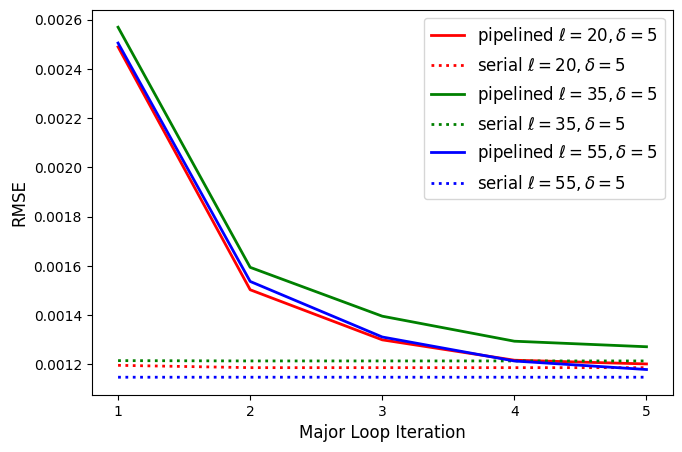

In [33]:
sgra_data = zip(data_p[0:3], data_np[0:3])

for i, data in enumerate(sgra_data):
    plt.plot(range(1, 6), data[0][1:], c=cols[i], linestyle=styles[0], label="pipelined " + labels[i], lw=2)
    plt.plot(range(1, 6), data[1][1:], c=cols[i], linestyle=styles[1], label="serial " + labels[i], lw=2)

plt.xticks([1,2,3,4,5])
    
plt.legend(loc="upper right", fontsize=12)
    
plt.xlabel("Major Loop Iteration", fontsize=12)
plt.ylabel("RMSE", fontsize=12)

#plt.title("Sgr A pipelined vs serial")

plt.savefig("../figures/full_serialvspipelined.png")

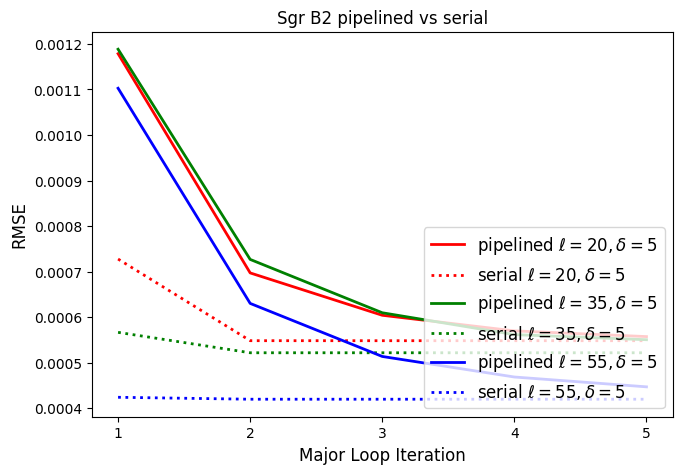

In [34]:
sgrb_data = zip(data_p[3:6], data_np[3:6])

for i, data in enumerate(sgrb_data):
    plt.plot(range(1, 6), data[0][1:], c=cols[i], linestyle=styles[0], label="pipelined " + labels[i], lw=2)
    plt.plot(range(1, 6), data[1][1:], c=cols[i], linestyle=styles[1], label="serial " + labels[i], lw=2)

plt.xticks([1,2,3,4,5])
    
plt.legend(loc="lower right", fontsize=12)
    
plt.xlabel("Major Loop Iteration", fontsize=12)
plt.ylabel("RMSE", fontsize=12)

plt.title("Sgr B2 pipelined vs serial")

plt.show()

Text(0.5, 1.0, 'Sgr C pipelined vs serial')

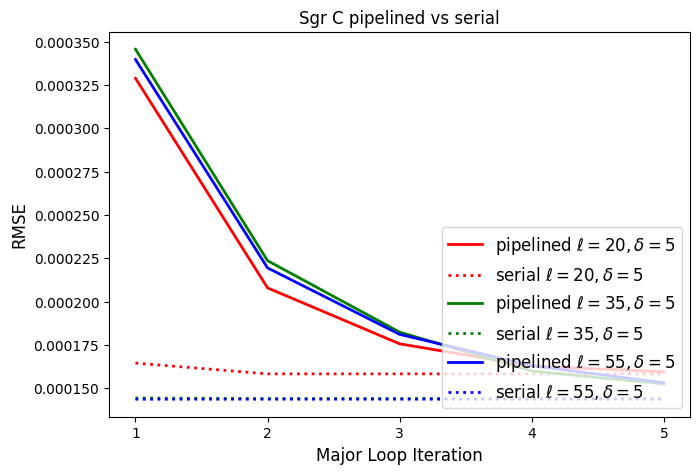

In [35]:
sgrc_data = zip(data_p[6:9], data_np[6:9])

for i, data in enumerate(sgrc_data):
    plt.plot(range(1, 6), data[0][1:], c=cols[i], linestyle=styles[0], label="pipelined " + labels[i], lw=2)
    plt.plot(range(1, 6), data[1][1:], c=cols[i], linestyle=styles[1], label="serial " + labels[i], lw=2)

plt.xticks([1,2,3,4,5])
    
plt.legend(loc="lower right", fontsize=12)
    
plt.xlabel("Major Loop Iteration", fontsize=12)
plt.ylabel("RMSE", fontsize=12)

plt.title("Sgr C pipelined vs serial")